### Remaining Tasks and Considerations

**Standard PCA or Kernelized PCA?**

We have decided to apply Standard PCA instead of Kernelized PCA because our interest lies in explaining the clusters. It seems more crucial for us to elucidate how much variance the individual Principal Components can actually explain, rather than achieving better clustering, i.e., significantly lower WCSS.

**Which Features Are We Going to Use?**

We will remove all features that provide information about geographical location, as we want to avoid any bias. Our objective is to see if there are similarities in happiness scores without relying on spatial proximity.

**How Many Clusters Do We Want?**

Unfortunately, the Elbow plot does not reveal an optimal number of clusters. We will apply another evaluation method, but generally, we aim to choose between 5-7 clusters. This range reflects the number of continents, suggesting our intent to explore if there are any inherent geographical or cultural implications in happiness, even in the absence of explicit geographical features.

**Cluster Algorithm**

We applied four different clustering algorithms on the principal components: bisecting k-means, k-means, hierarchical clustering, and DBSCAN.

- Bisecting k-means led to very unnatural, geometric class boundaries that did not seem suitable.
- DBSCAN also appeared unsuitable, as we have a very densely packed point cloud, resulting in few subdivided clusters.
- Both k-means and hierarchical clustering worked well and delivered almost identical results. Ultimately, both use distance as a measure of similarity, which seems very appropriate in our case.
- We noticed an impact of outliers on clustering results, particularly with clusters forming around outliers in population density (e.g., Hong Kong, Singapore, and Lesotho). To address this, we will remove extreme outliers and rerun the analysis, keeping these nuances in mind.


In [1]:
import pandas as pd
from scipy import stats
import numpy as np

# Load the dataset
data = pd.read_csv("data/final_data.csv")

# Drop 'region', 'continent', 'PC1', 'PC2', 'PC3'
data.drop(['region', 'continent', 'PC1', 'PC2', 'PC3'], axis=1, inplace=True)

# List of columns to check for outliers (excluding 'country' and 'year')
outlier_columns = [col for col in data.columns if col not in ['country', 'year']]

# Calculate Z-scores
z_scores = stats.zscore(data[outlier_columns])

# Convert z_scores to a NumPy array if it's not already
if not isinstance(z_scores, np.ndarray):
    z_scores = z_scores.to_numpy()

# Define a threshold for identifying outliers (e.g., Z-score > 3)
threshold = 3

# Find outliers in each column
outlier_indices_per_column = {column: np.where(z_scores[:, i] > threshold)[0] 
                              for i, column in enumerate(outlier_columns)}

# Count the number of outliers in each column
outlier_counts = {column: len(indices) for column, indices in outlier_indices_per_column.items()}

# Sort the columns by the number of outliers
sorted_outlier_counts = dict(sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted counts of outliers per column
for column, count in sorted_outlier_counts.items():
    print(f"{column}: {count} outliers")

# Create a combined mask for any row containing an outlier in any attribute
outlier_mask = np.zeros(len(data), dtype=bool)
for indices in outlier_indices_per_column.values():
    outlier_mask[indices] = True

# Filter out the rows with outliers
data_cleaned = data[~outlier_mask]

# Check the shape of the original and cleaned datasets
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {data_cleaned.shape}")


suicide_rate: 35 outliers
pop_density: 24 outliers
negative_affect: 17 outliers
generosity: 15 outliers
life_ladder: 0 outliers
log_gdp_per_capita: 0 outliers
social_suppoprt: 0 outliers
healthy_life_exp_at_birth: 0 outliers
freedom_to_make_life_choices: 0 outliers
perceptions_of_corruption: 0 outliers
positive_affect: 0 outliers
Original data shape: (1910, 13)
Cleaned data shape: (1819, 13)


In [2]:
# Assuming 'data_cleaned' is your DataFrame after outlier removal
# Ensure 'year' and 'country' are in the DataFrame
if 'year' in data_cleaned.columns and 'country' in data_cleaned.columns:
    # Reorder the columns to make 'country' the second attribute
    columns = ['year', 'country'] + [col for col in data_cleaned.columns if col not in ['year', 'country']]
    data_cleaned = data_cleaned[columns]
else:
    print("Either 'year' or 'country' column is missing in the DataFrame.")

# Check the new order of columns
print(data_cleaned.columns)


Index(['year', 'country', 'life_ladder', 'log_gdp_per_capita',
       'social_suppoprt', 'healthy_life_exp_at_birth',
       'freedom_to_make_life_choices', 'generosity',
       'perceptions_of_corruption', 'positive_affect', 'negative_affect',
       'pop_density', 'suicide_rate'],
      dtype='object')


#### PCA

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Selecting only the numerical features for PCA
numerical_features = data_cleaned.drop(['country', 'year'], axis=1)

# Standardizing the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(numerical_features)

# Applying PCA, computing only the first 3 principal components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(standardized_features)

# Creating a DataFrame for the first 3 principal components
pca_columns = ['PC1', 'PC2', 'PC3']
pca_df = pd.DataFrame(data=principal_components, columns=pca_columns)

# Concatenating the PCA DataFrame with the original 'data_cleaned' DataFrame
final_data = pd.concat([data_cleaned.reset_index(drop=True), pca_df], axis=1)

# Display the first few rows of the final DataFrame
final_data


,year,country,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,PC1,PC2,PC3
0,2008.0,Afghanistan,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.600,3.964290,-1.623176,-0.491903
1,2009.0,Afghanistan,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.400,3.079301,-1.636933,-0.726216
2,2010.0,Afghanistan,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.300,2.960657,-1.490737,-0.423930
3,2011.0,Afghanistan,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.100,3.611757,-1.420968,-0.502139
4,2012.0,Afghanistan,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.000,3.214656,-1.977606,-0.652195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016.0,Zimbabwe,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209,37.359969,16.800,1.429331,-0.007387,-1.866828
1815,2017.0,Zimbabwe,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224,38.131320,15.000,1.348954,-0.325163,-1.771706
1816,2018.0,Zimbabwe,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212,38.909614,14.000,1.617021,-0.027347,-1.605599
1817,2019.0,Zimbabwe,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235,39.691374,14.100,2.346806,0.169438,-1.497737


In [4]:
# Get the explained variance ratio for the first 3 principal components
explained_variance = pca.explained_variance_ratio_

# Print the explained variance ratio
print("Explained Variance Ratio by Standard PCA Components:")
for i, variance in enumerate(explained_variance):
    print(f"PC{i+1}: {variance:.2f}")

# Calculating squared loadings (proportions) for the first 3 components
loadings = pca.components_.T
squared_loadings = np.square(loadings)

# Calculating the proportion of the variance explained by each variable for each PC
proportions = squared_loadings / np.sum(squared_loadings, axis=0)

# Converting proportions to percentages for the first 3 components
proportions_percentage = proportions * 100

# Displaying top loadings as percentages for each of the first 3 PCs
for i in range(3):  # Adjusted for the first 3 PCs
    print(f"\nTop loadings as percentages for PC{i+1}:")
    top_loadings = pd.Series(proportions_percentage[:, i], index=numerical_features.columns)
    print(top_loadings.sort_values(ascending=False).head(5))


Explained Variance Ratio by Standard PCA Components:
PC1: 0.40
PC2: 0.15
PC3: 0.11

Top loadings as percentages for PC1:
life_ladder                     18.625190
log_gdp_per_capita              15.762974
social_suppoprt                 14.696348
healthy_life_exp_at_birth       14.234606
freedom_to_make_life_choices    10.810591
dtype: float64

Top loadings as percentages for PC2:
generosity                      29.813268
suicide_rate                    17.835115
freedom_to_make_life_choices    10.790415
positive_affect                 10.454876
log_gdp_per_capita               9.500168
dtype: float64

Top loadings as percentages for PC3:
pop_density                  36.051427
negative_affect              35.296864
healthy_life_exp_at_birth     9.606229
suicide_rate                  8.132502
log_gdp_per_capita            4.764375
dtype: float64


In [5]:
import plotly.express as px

# 3D scatter plot for visualizing clusters
fig = px.scatter_3d(final_data, x='PC1', y='PC2', z='PC3', color='life_ladder', 
                    title='3D PCA Visualization Colored by Life Ladder')
fig.show()


#### Clustering Analysis

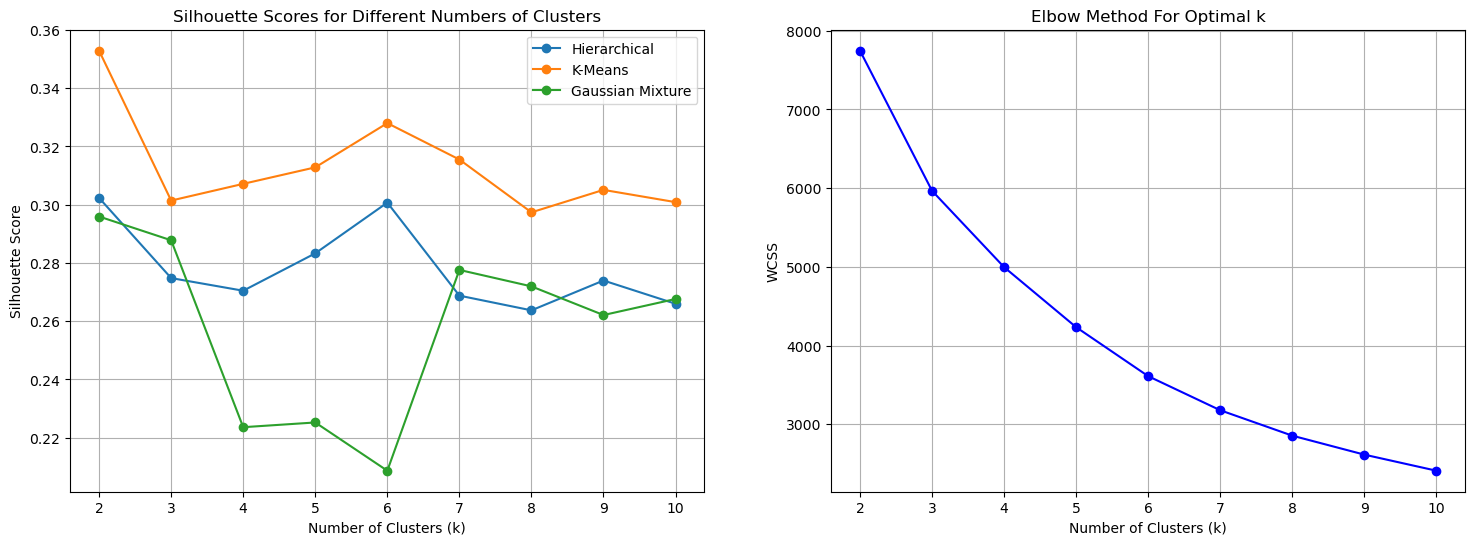

In [6]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'final_data' is your DataFrame prepared for PCA with 'PC1', 'PC2', 'PC3'
X = final_data[['PC1', 'PC2', 'PC3']]

# Ranges of k to test
k_values = range(2, 11)

# Lists to store silhouette scores and WCSS
silhouette_scores_hierarchical = []
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
wcss = []

for k in k_values:
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=k)
    labels_hierarchical = hierarchical.fit_predict(X)
    score_hierarchical = silhouette_score(X, labels_hierarchical)
    silhouette_scores_hierarchical.append(score_hierarchical)
    
    # K-Means Clustering with explicit n_init setting
    kmeans = KMeans(n_clusters=k, n_init=10)
    labels_kmeans = kmeans.fit_predict(X)
    score_kmeans = silhouette_score(X, labels_kmeans)
    silhouette_scores_kmeans.append(score_kmeans)
    
    # Compute WCSS for the elbow plot
    wcss.append(kmeans.inertia_)

    # Gaussian Mixture Model Clustering
    gmm = GaussianMixture(n_components=k, random_state=0)
    labels_gmm = gmm.fit_predict(X)
    score_gmm = silhouette_score(X, labels_gmm)
    silhouette_scores_gmm.append(score_gmm)

# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Silhouette Score Plot
ax[0].plot(k_values, silhouette_scores_hierarchical, label='Hierarchical', marker='o')
ax[0].plot(k_values, silhouette_scores_kmeans, label='K-Means', marker='o')
ax[0].plot(k_values, silhouette_scores_gmm, label='Gaussian Mixture', marker='o')
ax[0].set_xticks(k_values)
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Scores for Different Numbers of Clusters')
ax[0].legend()
ax[0].grid(True)

# Elbow Plot
ax[1].plot(k_values, wcss, marker='o', linestyle='-', color='b')
ax[1].set_xticks(k_values)
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('WCSS')
ax[1].set_title('Elbow Method For Optimal k')
ax[1].grid(True)

plt.show()


In [16]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# Assuming 'final_data' is your DataFrame prepared for clustering

# Number of clusters for Hierarchical and K-Means Clustering
n_clusters = 5

# Perform Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
final_data['hierarchical_cluster'] = hierarchical.fit_predict(final_data[['PC1', 'PC2', 'PC3']])

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters)
final_data['kmeans_cluster'] = kmeans.fit_predict(final_data[['PC1', 'PC2', 'PC3']])

# Function to sort clusters based on median 'life_ladder' and update labels
def sort_and_label_clusters(data, cluster_col, score_col):
    # Calculate median score for each cluster
    median_scores = data.groupby(cluster_col)[score_col].median()

    # Sort clusters by median score in ascending order and create a label mapping
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(median_scores.sort_values().index)}

    # Apply the label mapping to the cluster column
    return data[cluster_col].map(label_mapping)

# Apply the sorting and labeling to both Hierarchical and K-Means clusters
final_data['hierarchical_cluster'] = sort_and_label_clusters(final_data, 'hierarchical_cluster', 'life_ladder')
final_data['kmeans_cluster'] = sort_and_label_clusters(final_data, 'kmeans_cluster', 'life_ladder')

# Display the first few rows of the final DataFrame with updated cluster labels
final_data

c:\Users\thali\anaconda3\envs\py310_remote_sensing\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,year,country,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,PC1,PC2,PC3,hierarchical_cluster,kmeans_cluster
0,2008.0,Afghanistan,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.600,3.964290,-1.623176,-0.491903,0,0
1,2009.0,Afghanistan,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.400,3.079301,-1.636933,-0.726216,0,0
2,2010.0,Afghanistan,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.300,2.960657,-1.490737,-0.423930,0,0
3,2011.0,Afghanistan,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.100,3.611757,-1.420968,-0.502139,0,0
4,2012.0,Afghanistan,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.000,3.214656,-1.977606,-0.652195,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016.0,Zimbabwe,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209,37.359969,16.800,1.429331,-0.007387,-1.866828,0,0
1815,2017.0,Zimbabwe,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224,38.131320,15.000,1.348954,-0.325163,-1.771706,0,0
1816,2018.0,Zimbabwe,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212,38.909614,14.000,1.617021,-0.027347,-1.605599,0,0
1817,2019.0,Zimbabwe,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235,39.691374,14.100,2.346806,0.169438,-1.497737,0,0


In [17]:
# Check class balances for Hierarchical Clusters
print("Class Balances for Hierarchical Clusters:")
print(final_data['hierarchical_cluster'].value_counts())

# Check class balances for K-Means Clusters
print("\nClass Balances for K-Means Clusters:")
print(final_data['kmeans_cluster'].value_counts())


Class Balances for Hierarchical Clusters:
hierarchical_cluster
0    486
2    465
1    353
3    263
4    252
Name: count, dtype: int64

Class Balances for K-Means Clusters:
kmeans_cluster
2    456
0    444
3    367
4    286
1    266
Name: count, dtype: int64


#### Variance Analysis in K-Means

In [18]:
import numpy as np
import pandas as pd

# Assuming 'final_data' is your DataFrame and 'kmeans_cluster' is the cluster assignment from K-Means
X = final_data[['PC1', 'PC2', 'PC3']]  # Data used for clustering
cluster_labels = final_data['kmeans_cluster']

# Calculate variance within each cluster
cluster_variances = []
for k in np.unique(cluster_labels):
    cluster_data = X[cluster_labels == k]
    cluster_variance = cluster_data.var()
    cluster_variances.append(cluster_variance.mean())  # Get the mean variance for the cluster

# Convert to a DataFrame for easier visualization
cluster_variance_df = pd.DataFrame(cluster_variances, columns=['Variance'])

# Display the variances
print("Variance within each cluster:")
print(cluster_variance_df)

# Calculate overall mean variance
mean_variance = np.mean(cluster_variances)

# Check if each cluster's variance is within a certain percentage of the mean variance
is_roughly_equal = cluster_variance_df.apply(lambda x: np.isclose(x, mean_variance, rtol=0.2)).all(axis=1)
print("\nAre variances roughly equal across clusters?")
print(is_roughly_equal)


Variance within each cluster:
   Variance
0  0.830064
1  0.820280
2  0.945852
3  0.724381
4  0.459015

Are variances roughly equal across clusters?
0     True
1     True
2    False
3     True
4    False
dtype: bool


In [19]:
import numpy as np
import pandas as pd

# Assuming 'final_data' is your DataFrame and 'kmeans_cluster' is the cluster assignment from K-Means
X = final_data[['PC1', 'PC2', 'PC3']]  # Data used for clustering
cluster_labels = final_data['kmeans_cluster']

# Calculate variance within each cluster for each dimension
cluster_variances = {k: X[cluster_labels == k].var() for k in np.unique(cluster_labels)}

# Convert to a DataFrame for easier visualization
cluster_variance_df = pd.DataFrame(cluster_variances)

# Display the variances
print("Variance within each cluster for each dimension:")
print(cluster_variance_df)

# Checking if variances are roughly equal within each dimension across clusters
tolerance = 0.2  # Tolerance level, e.g., 20%
variance_comparison = cluster_variance_df.apply(lambda col: np.all(np.isclose(col, col.mean(), rtol=tolerance)), axis=1)

# Display the comparison result
print("\nAre variances roughly equal within each dimension across clusters?")
print(variance_comparison)


Variance within each cluster for each dimension:
            0         1         2         3         4
PC1  1.093331  0.588209  0.594553  0.870547  0.482543
PC2  0.650643  1.027818  0.643796  0.554379  0.546757
PC3  0.746218  0.844814  1.599207  0.748217  0.347744

Are variances roughly equal within each dimension across clusters?
PC1    False
PC2    False
PC3    False
dtype: bool


#### Visualization

In [20]:
import plotly.express as px

# 3D scatter plot for visualizing clusters
fig = px.scatter_3d(final_data, x='PC1', y='PC2', z='PC3', color='hierarchical_cluster', 
                    title='3D PCA Visualization Colored by Hierarchical Cluster')
fig.show()


In [21]:
import plotly.express as px

# 3D scatter plot for visualizing clusters
fig = px.scatter_3d(final_data, x='PC1', y='PC2', z='PC3', color='kmeans_cluster', 
                    title='3D PCA Visualization Colored by K-means Cluster')
fig.show()


### Clustering Algorithm Evaluation

#### Overview
- Evaluated three clustering algorithms: K-Means, Hierarchical Clustering, and Gaussian Mixture Models (GMM).
- Utilized silhouette score analysis for \( k = 2 \) to \( 10 \) to find the optimal number of clusters, as the elbow plot did not provide a clear indication.

#### Key Findings
- **K-Means Clustering**: Consistently higher silhouette scores, peaking at \( k = 2 \) and \( 6 \). Assumes equal variances across clusters.
- **Hierarchical Clustering**: Comparable peaks in silhouette scores at \( k = 2 \) and \( 6 \) when using the default Ward linkage. Switching to single linkage improved results at \( k = 5 \), almost matching K-Means at \( k = 6 \).
- **Gaussian Mixture Models (GMM)**: Underperformed for \( k = 4 \) to \( 6 \), which are key numbers of interest (e.g., number of continents), suggesting it's not suitable for this case.

#### Variance Analysis in K-Means
- Investigated the assumption of equal variances in K-Means clusters.
- Result: Variances are not equal within each dimension across clusters.

#### Issues with Hierarchical Clustering
- While Hierarchical Clustering with single linkage at \( k = 5 \) had a near-comparable silhouette score to K-Means at \( k = 6 \), visual inspection revealed poor clustering quality.
- Notably, 3 clusters contained only a single data point each, which is not desirable.

#### Class Balances Analysis
- Observed significant class imbalance in clusters when using ( k = 6 \) for both Hierarchical and K-Means clustering.
    - For Hierarchical Clustering, one cluster contained only 24 out of 1819 instances.
    - For K-Means, one cluster contained 30 out of 1819 instances.
- Such imbalance in cluster sizes can lead to skewed analyses and interpretations.

#### Final Decision
- **Decision**: Opting for Hierarchical Clustering with Ward linkage at \( k = 5 \), despite a slightly lower silhouette score.
- **Rationale**: At \( k = 5 \) clusters are more balanced, and the method still aligns with the dataset's variance characteristics.
- **Consideration of Silhouette Score and Class Balances**: The decision considers both the silhouette score and the need for more balanced cluster sizes, ensuring a more representative and robust clustering solution.

#### Conclusion
- **Hierarchical Clustering with Ward Linkage at k = 5**: Selected due to its combination of methodological fit with the data's variance characteristics and more balanced class sizes.

- This decision underscores the importance of not only relying on empirical metrics like silhouette scores but also considering the practical aspects of cluster sizes and their balance, thus ensuring a more holistic approach to clustering.




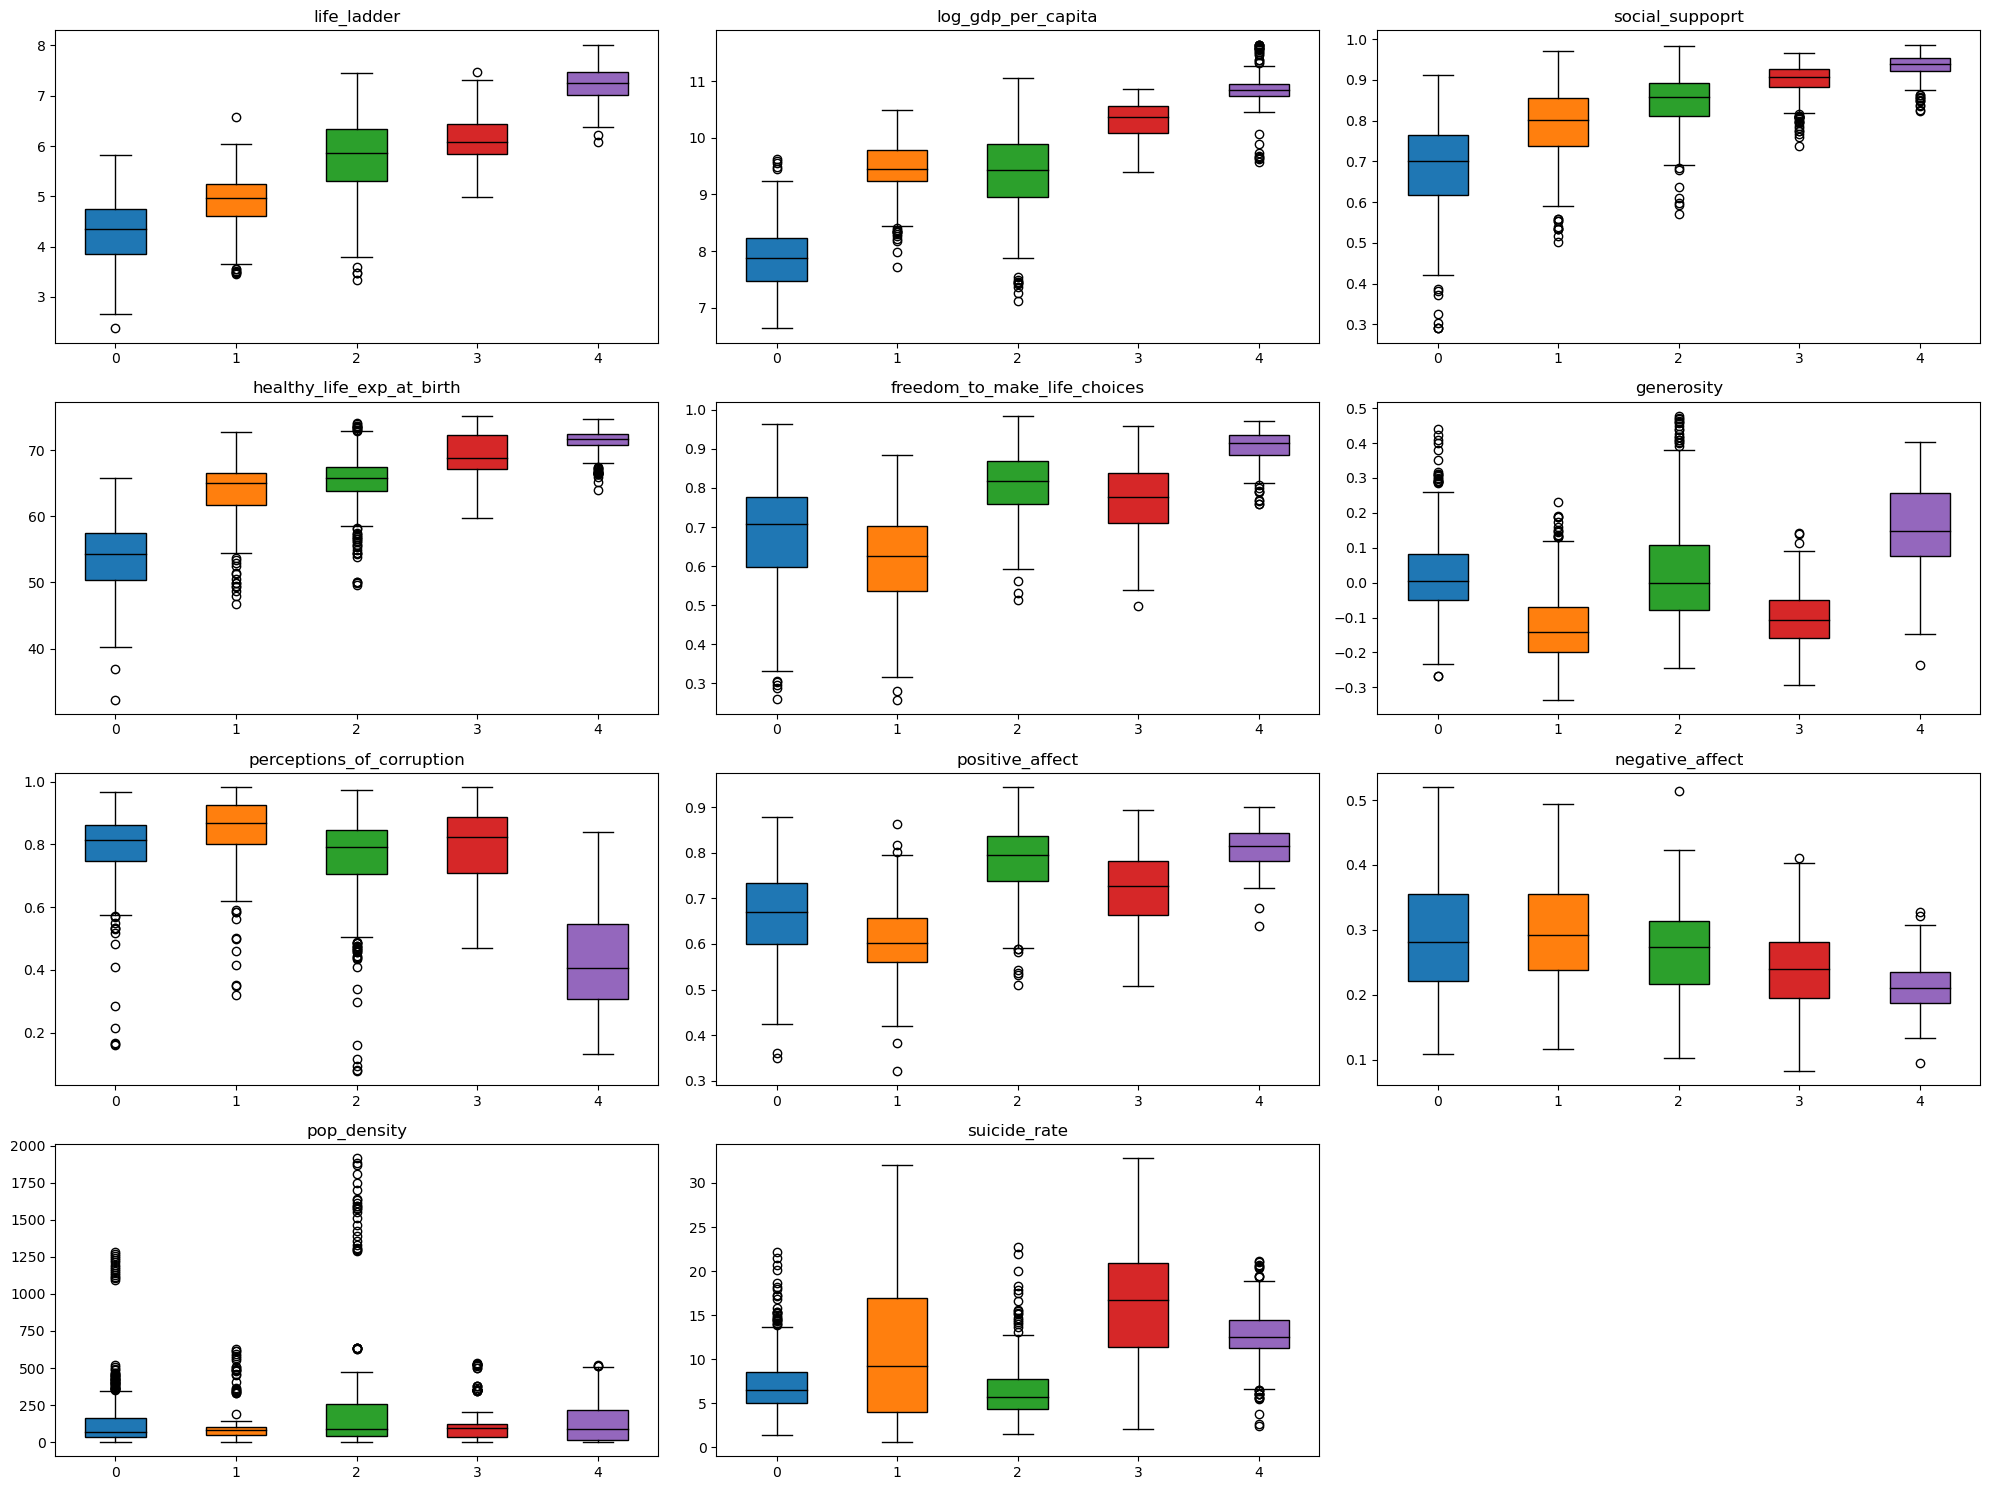

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_data' contains the 'hierarchical_cluster' column
# and the clusters are already sorted by median 'life_ladder'

# Define a default color palette for the clusters
color_map = sns.color_palette("tab10", n_colors=final_data['hierarchical_cluster'].nunique())

# List of numerical columns from 'life_ladder' to 'suicide_rate'
numerical_columns = final_data.loc[:, 'life_ladder':'suicide_rate'].columns

# Get sorted unique cluster labels based on median 'life_ladder'
# Calculate median 'life_ladder' for each cluster and get the sorted cluster labels
sorted_cluster_labels = final_data.groupby('hierarchical_cluster')['life_ladder'].median().sort_values().index.tolist()

# Iterate through each numerical column to create a boxplot
plt.figure(figsize=(20, 15))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)

    # Create a list of data for each cluster for the current column
    data_to_plot = [final_data[final_data['hierarchical_cluster'] == cluster_label][column] 
                    for cluster_label in sorted_cluster_labels]

    bp = plt.boxplot(data_to_plot, patch_artist=True)

    # Set the colors for each boxplot
    for patch, color in zip(bp['boxes'], color_map):
        patch.set_facecolor(color)

    # Change the color of the median line
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1)

    plt.title(column)
    plt.xticks(ticks=range(1, len(sorted_cluster_labels) + 1), labels=sorted_cluster_labels)
    plt.xlim(0.5, len(sorted_cluster_labels) + 0.5)

plt.tight_layout()
plt.show()


#### Save the final clustered data for prediction!

In [23]:
# # Assuming final_data is your pandas DataFrame
# final_data = final_data.drop('kmeans_cluster', axis=1)
# final_data = final_data.rename(columns={'hierarchical_cluster': 'cluster'})

# # Save the modified DataFrame to a CSV file
# final_data.to_csv('prediction_data.csv', index=False)